# Building an image similarity system with 🤗 Datasets FAISS

This is follow-up notebook of the tutorial introduced in [this PR](https://github.com/huggingface/notebooks/pull/270). 🤗 Datasets supports a [FAISS](https://github.com/facebookresearch/faiss) integration that is useful for building similarity systems. You can learn more about this integration [here](https://huggingface.co/docs/datasets/faiss_es).

## Installations

In [1]:
!pip install transformers datasets faiss-cpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00


## Load model for computing embeddings of the candidate images

In [2]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load candidate subset

In [3]:
from datasets import load_dataset

seed = 42
num_samples = 100
dataset = load_dataset("beans", split="train")
candidate_dataset = dataset.shuffle(seed=seed).select(range(num_samples))

README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

## Extract embeddings

In [4]:
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

In [5]:
dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})
dataset_with_embeddings.add_faiss_index(column='embeddings')

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image_file_path', 'image', 'labels', 'embeddings'],
    num_rows: 100
})

## Load test set for querying

In [6]:
test_ds = load_dataset("beans", split="test")

## Select a random sample and run the query

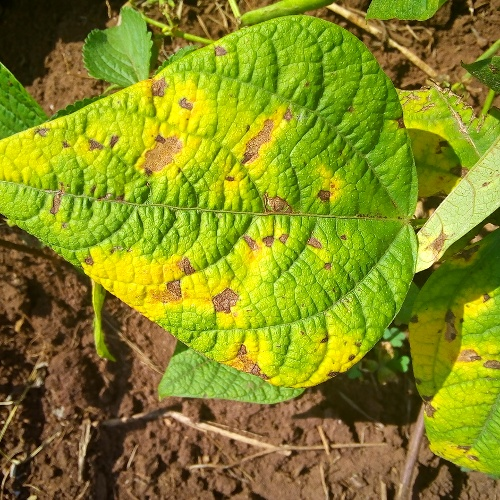

In [9]:
import numpy as np

random_index = np.random.choice(len(test_ds))
query_image = test_ds[random_index]["image"]
query_image

In [10]:
def get_neighbors(query_image, top_k=5):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples

scores, retrieved_examples = get_neighbors(query_image)

In [11]:
from PIL import Image

def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

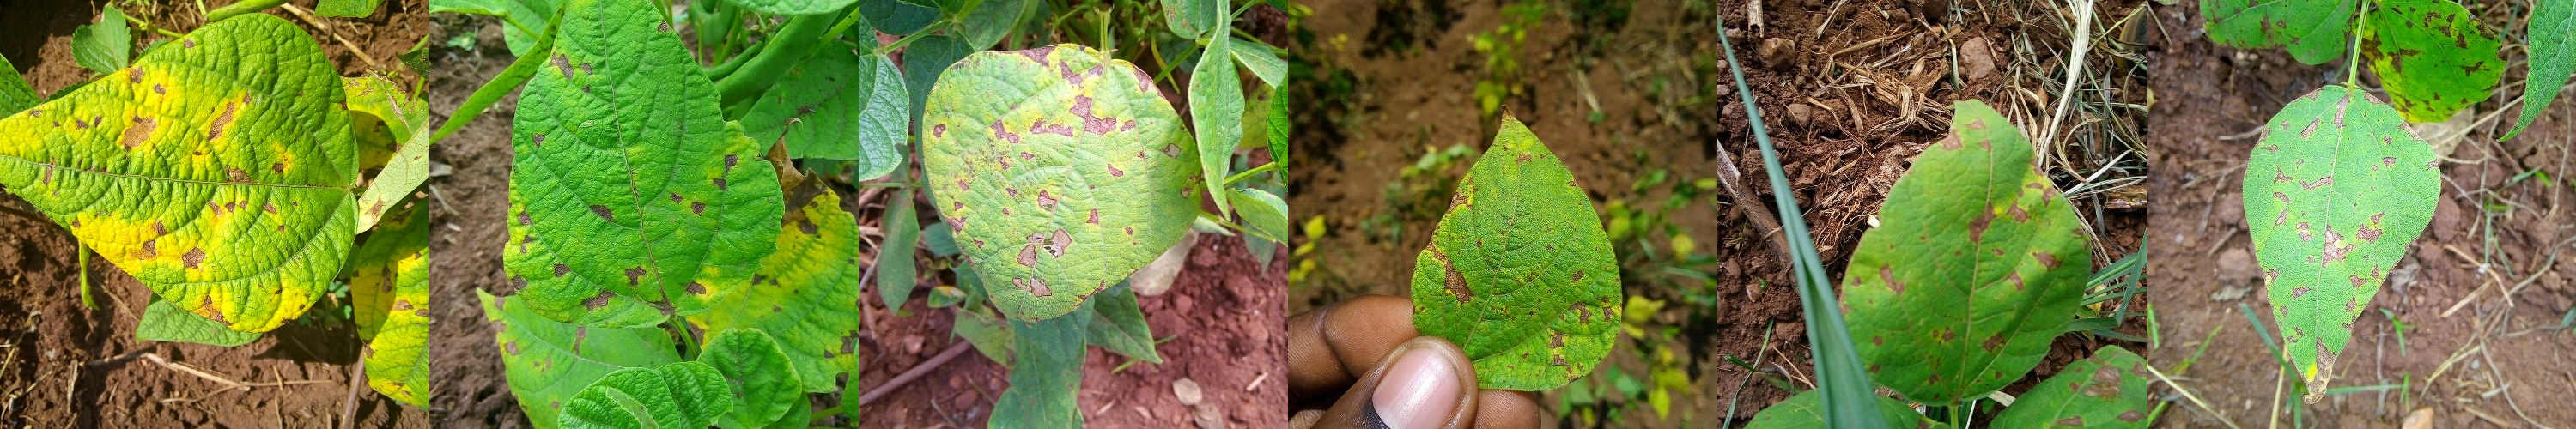

In [12]:
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 1, len(images))